In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/
%mkdir ai
%cd ./ai
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/ai


In [2]:
!git clone https://github.com/kairess/ACGPN.git
%cd ACGPN

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 7.58 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/drive/MyDrive/ai/ACGPN


## Dependencies

In [3]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

In [4]:
import gdown
import numpy as np
from PIL import Image
import IPython
import gdown
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [5]:
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [6]:
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
!git clone https://github.com/levindabhi/U-2-Net.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (769/769), done.
remote: Compressing objects: 100% (583/583), done.
remote: Total 769 (delta 184), reused 661 (delta 175), pack-reused 0
Receiving objects: 100% (769/769), 3.89 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Updating files: 100% (546/546), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (439/439), done.
remote: Total 822 (delta 389), reused 793 (delta 379), pack-reused 0
Receiving objects: 100% (822/822), 30.71 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (389/389), done.
Updating files: 100% (173/173), done.


## 사전학습 모델 다운로드

### 포즈 예측 모델

In [7]:
#에러난 부분

!gdown --fuzzy https://drive.google.com/file/d/1p9fuCGKGhtdnUvJzxW3JRx3XB2HU_J1w/view?usp=sharing -O pose/pose_iter_440000.caffemodel

Downloading...
From (uriginal): https://drive.google.com/uc?id=1p9fuCGKGhtdnUvJzxW3JRx3XB2HU_J1w
From (redirected): https://drive.google.com/uc?id=1p9fuCGKGhtdnUvJzxW3JRx3XB2HU_J1w&confirm=t&uuid=5268fbbc-7f27-471b-8e64-a1326dcf6fda
To: /content/drive/MyDrive/ai/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:01<00:00, 135MB/s]


### 휴먼 세그멘테이션 마스크 생성 모델

In [8]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=7579a0da-e87c-4eb4-9915-ff06e8ab2431
To: /content/drive/MyDrive/ai/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:01<00:00, 204MB/s]


'lip_final.pth'

### U2Net 모델

옷 마스크 추출 모델

In [9]:

%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd ..

/content/drive/MyDrive/ai/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/drive/MyDrive/ai/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 218MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=8e3f94c1-59f4-4a6d-bf94-d91e67d0e635
To: /content/drive/MyDrive/ai/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:02<00:00, 72.2MB/s]
...load U2NEP---4.7 MB
/content/drive/MyDrive/ai/ACGPN


### ACGPN 모델

In [10]:
!mkdir checkpoints

gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
From (redirected): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx&confirm=t&uuid=233c6a43-b7af-48f0-ba75-b9bd38ca9e7c
To: /content/drive/MyDrive/ai/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:03<00:00, 157MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


## 전처리

### 옷 마스크 추출

In [11]:
from googleapiclient.discovery import build
from google.colab import auth
import io
from googleapiclient.http import MediaIoBaseDownload

# Authenticate and create the drive service client
auth.authenticate_user()
drive_service = build('drive', 'v3')

# ID of the zip file on Google Drive
file_id = '1j9BEF9RoQDH7PO7ntwwfM0tplR-YWM6k'

# Request the file metadata
file_metadata = drive_service.files().get(fileId=file_id).execute()

# Create a buffer to store the downloaded file
file_buffer = io.BytesIO()

# Download the file
request = drive_service.files().get_media(fileId=file_id)
downloader = MediaIoBaseDownload(file_buffer, request)
done = False
while done is False:
    _, done = downloader.next_chunk()

# Save the downloaded zip file
with open('./inputs/cloth/cloth.zip', 'wb') as f:
    f.write(file_buffer.getvalue())
!unzip ./inputs/cloth/cloth.zip -d ./inputs/cloth/
!rm -f ./inputs/cloth/cloth.zip

Archive:  ./inputs/cloth/cloth.zip
  inflating: ./inputs/cloth/000001_1.jpg  
  inflating: ./inputs/cloth/000010_1.jpg  
  inflating: ./inputs/cloth/000020_1.jpg  
  inflating: ./inputs/cloth/000028_1.jpg  
  inflating: ./inputs/cloth/000038_1.jpg  
  inflating: ./inputs/cloth/000048_1.jpg  
  inflating: ./inputs/cloth/000057_1.jpg  
  inflating: ./inputs/cloth/000066_1.jpg  
  inflating: ./inputs/cloth/000074_1.jpg  
  inflating: ./inputs/cloth/000082_1.jpg  
  inflating: ./inputs/cloth/000097_1.jpg  
  inflating: ./inputs/cloth/000109_1.jpg  
  inflating: ./inputs/cloth/000118_1.jpg  
  inflating: ./inputs/cloth/000129_1.jpg  
  inflating: ./inputs/cloth/000143_1.jpg  
  inflating: ./inputs/cloth/000154_1.jpg  
  inflating: ./inputs/cloth/000164_1.jpg  
  inflating: ./inputs/cloth/000174_1.jpg  
  inflating: ./inputs/cloth/000183_1.jpg  
  inflating: ./inputs/cloth/000192_1.jpg  
  inflating: ./inputs/cloth/000200_1.jpg  
  inflating: ./inputs/cloth/000209_1.jpg  
  inflating: ./inpu

In [12]:
from googleapiclient.discovery import build
from google.colab import auth
import io
from googleapiclient.http import MediaIoBaseDownload

# Authenticate and create the drive service client
auth.authenticate_user()
drive_service = build('drive', 'v3')

# ID of the zip file on Google Drive
file_id = '1piaJ_fIBCdgCoPYnHzbL6wuyMr5B3pTa'

# Request the file metadata
file_metadata = drive_service.files().get(fileId=file_id).execute()

# Create a buffer to store the downloaded file
file_buffer = io.BytesIO()

# Download the file
request = drive_service.files().get_media(fileId=file_id)
downloader = MediaIoBaseDownload(file_buffer, request)
done = False
while done is False:
    _, done = downloader.next_chunk()

# Save the downloaded zip file
with open('./inputs/img/img.zip', 'wb') as f:
    f.write(file_buffer.getvalue())
!unzip ./inputs/img/img.zip -d ./inputs/img/

!rm -f ./inputs/img/img.zip

Archive:  ./inputs/img/img.zip
   creating: ./inputs/img/img/.ipynb_checkpoints/
  inflating: ./inputs/img/img/000143_0.jpg  
  inflating: ./inputs/img/img/000097_0.jpg  
  inflating: ./inputs/img/img/000118_0.jpg  
  inflating: ./inputs/img/img/000192_0.jpg  
  inflating: ./inputs/img/img/000010_0.jpg  
  inflating: ./inputs/img/img/000248_0.jpg  
  inflating: ./inputs/img/img/000066_0.jpg  
  inflating: ./inputs/img/img/000020_0.jpg  
  inflating: ./inputs/img/img/000274_0.jpg  
  inflating: ./inputs/img/img/000258_0.jpg  
  inflating: ./inputs/img/img/000154_0.jpg  
  inflating: ./inputs/img/img/000200_0.jpg  
  inflating: ./inputs/img/img/000220_0.jpg  
  inflating: ./inputs/img/img/000266_0.jpg  
  inflating: ./inputs/img/img/000240_0.jpg  
  inflating: ./inputs/img/img/000074_0.jpg  
  inflating: ./inputs/img/img/000082_0.jpg  
  inflating: ./inputs/img/img/000038_0.jpg  
  inflating: ./inputs/img/img/000109_0.jpg  
  inflating: ./inputs/img/img/000183_0.jpg  
  inflating: ./inpu

In [13]:
#방법1
#흰옷 저장하는 것
# cloth_name = f'cloth_{int(time.time())}.png'
from glob import glob

cloth_path = glob("inputs/cloth/*")
print(cloth_path)
# cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth')))
for path in cloth_path:
  print(path)
  cloth = Image.open(path)
  cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')

  center_y = 96
  center_x = 128

  cloth_arr = np.array(cloth)
  if np.mean(cloth_arr[center_y, center_x]) >= 220: # white cloth
    img_name = path.split('/')[-1]
    img_name = img_name.replace('.jpg', '.png')
    cloth.save('Data_preprocessing/test_color/'+img_name)


# cloth = Image.open(cloth_path)
# cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
# cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

# Image.open(f'Data_preprocessing/test_edge/{img_name}')

['inputs/cloth/000001_1.jpg', 'inputs/cloth/000010_1.jpg', 'inputs/cloth/000020_1.jpg', 'inputs/cloth/000028_1.jpg', 'inputs/cloth/000038_1.jpg', 'inputs/cloth/000048_1.jpg', 'inputs/cloth/000057_1.jpg', 'inputs/cloth/000066_1.jpg', 'inputs/cloth/000074_1.jpg', 'inputs/cloth/000082_1.jpg', 'inputs/cloth/000097_1.jpg', 'inputs/cloth/000109_1.jpg', 'inputs/cloth/000118_1.jpg', 'inputs/cloth/000129_1.jpg', 'inputs/cloth/000143_1.jpg', 'inputs/cloth/000154_1.jpg', 'inputs/cloth/000164_1.jpg', 'inputs/cloth/000174_1.jpg', 'inputs/cloth/000183_1.jpg', 'inputs/cloth/000192_1.jpg', 'inputs/cloth/000200_1.jpg', 'inputs/cloth/000209_1.jpg', 'inputs/cloth/000220_1.jpg', 'inputs/cloth/000228_1.jpg', 'inputs/cloth/000240_1.jpg', 'inputs/cloth/000248_1.jpg', 'inputs/cloth/000258_1.jpg', 'inputs/cloth/000266_1.jpg', 'inputs/cloth/000274_1.jpg', 'inputs/cloth/000284_1.jpg']
inputs/cloth/000001_1.jpg
inputs/cloth/000010_1.jpg
inputs/cloth/000020_1.jpg
inputs/cloth/000028_1.jpg
inputs/cloth/000038_1.jpg

### 모델 포즈, 세그멘테이션

In [14]:
#전체 색깔의 평균내기 2분에 1 이상 240값이 차지하고 있다면 흰옷으로 치는 것!
!mkdir Data_preprocessing/re_img

img_name = f'img_{int(time.time())}.png'
from glob import glob
data = glob('inputs/img/img/*')


for i in data:
  img = Image.open(i)
  img = img.resize((368, 368),Image.BICUBIC)
  checker = np.array(img)
  len_white = np.where(checker>=240)
  if len(len_white[0]) >= (192*256)/2:
    save_path = i.split('/')[-1]
    save_path = save_path.replace('.jpg', '.png')
    img.save('Data_preprocessing/re_img/'+save_path)
    img_name = i


!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/re_img' --output-dir 'Data_preprocessing/test_label'

# img_name = 'inputs/img/img/testtest.png'
temp_path =  img_name.split('/')[-1].split('.')[-2]
pose_path = 'Data_preprocessing/test_pose/' + temp_path + '_keypoints.json'
print(pose_path)
print(img_name)
#pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

generate_pose_keypoints(img_name, pose_path)

100% 17/17 [00:02<00:00,  6.95it/s]
Data_preprocessing/test_pose/000028_0_keypoints.json
inputs/img/img/000028_0.jpg
File saved at Data_preprocessing/test_pose/000028_0_keypoints.json


## 추론

In [15]:
#cloth_name은 어떠한 옷을 적용할 것인지 옷 파일 명을 적어야함(확장자 포함)
img_name = img_name.split('/')[-1]
img_name = img_name.replace('.jpg', '.png')
cloth_name = '000020_1.png'
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
  f.write(f'{img_name} {cloth_name}')
!pwd
!mv Data_preprocessing/re_img/* Data_preprocessing/test_img
# !ls | grep 'Data_preprocessing/test_img/.jpg' | cut -d . -f 1 | while read line; do mv $line.jpg $line.png; done

/content/drive/MyDrive/ai/ACGPN


In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
try:
  !python test.py
except:
  pass

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

## 결과

/content/drive/MyDrive/ai/ACGPN


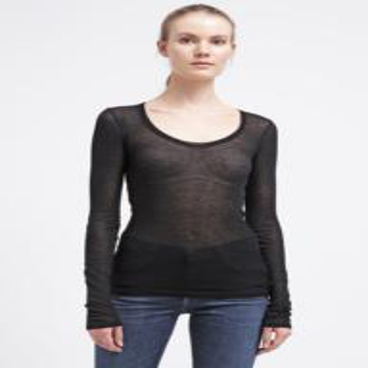

In [17]:
!pwd

Image.open(f'Data_preprocessing/test_img/{img_name}')

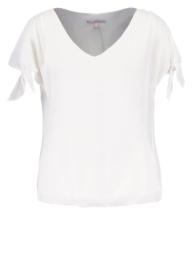

In [18]:
Image.open(f'Data_preprocessing/test_color/{cloth_name}')

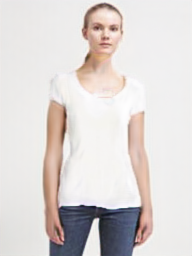

In [19]:
Image.open(f'results/test/try-on/{img_name}')